In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

# 1次元ユークリッド空間

In [3]:
import random
from npmath.space import NormSpace, R

class OneDimEuclideanSpace(NormSpace):
    def __init__(self):
        super().__init__(lambda x: R(x))
        
    def norm(self, x):
        return abs(x.value)

V = OneDimEuclideanSpace()
x, y, z = V.take(1., 2., 3.)

print(V.norm(x))
print(V.norm(y))
print(V.norm(z))

1.0
2.0
3.0


# ノルムの条件をみたすことのテスト

In [4]:
from abc import ABC, abstractmethod
import random
from npmath.space import NormSpace, R, test_norm_conditions_fulfilled

class AutomatedTestable(ABC):
    @abstractmethod
    def zeros(self): pass
    
    @abstractmethod
    def random_scalar(self): pass
    
    @abstractmethod
    def random_take(self): pass

class OneDimEuclideanSpace(NormSpace, AutomatedTestable):
    def __init__(self):
        super().__init__(lambda x: R(x))
        
    def norm(self, x):
        return abs(x.value)
    
    def zeros(self):
        return self.take(0.)

    def random_scalar(self):
        return random.uniform(-1., 1.)
    
    def random_take(self):
        return self.take(random.uniform(-1., 1.))
    
V = OneDimEuclideanSpace()
for _ in range(0, 100):
    test_norm_conditions_fulfilled(V)

In [5]:
class BadOneDimEuclideanSpace(OneDimEuclideanSpace):
    def norm(self, x):
        return x.value
    
    def random_scalar(self):
        return random.uniform(-1., -0.1)
    
    def random_take(self):
        return self.take(random.uniform(-1., -0.1))    

V = BadOneDimEuclideanSpace()
try:
    test_norm_conditions_fulfilled(V)
except Exception as e:
    print(f"{e.__class__.__name__}: {e}")

AssertionError: 


In [6]:
from npmath.space import NormSpace, MetricSpace, R, test_metric_conditions_fulfilled
    
class OneDimEuclideanSpace(NormSpace, MetricSpace, AutomatedTestable):
    def __init__(self):
        super().__init__(lambda x: R(x))
        
    def norm(self, x):
        return abs(x.value)
    
    def distance(self, x, y):
        return self.norm(x - y)
    
    def zeros(self):
        return self.take(0.)

    def random_scalar(self):
        return random.uniform(-1., 1.)
    
    def random_take(self):
        return self.take(random.uniform(-1., 1.))
    
V = OneDimEuclideanSpace()
for _ in range(0, 100):
    test_metric_conditions_fulfilled(V)

In [7]:
from npmath.space import RealVector, MetricVectorSpace, AutomatedTestable, test_metric_conditions_fulfilled

class TestableMetricVectorSpace(MetricVectorSpace, AutomatedTestable):
    def zeros(self):
        return self.take(np.zeros(self.ndm))

    def random_scalar(self):
        return random.uniform(-1., 1.)
    
    def random_take(self):
        return self.take(np.random.rand(self.ndim))

V = TestableMetricVectorSpace(RealVector, ndim=3)
for _ in range(0, 100):
    test_metric_conditions_fulfilled(V)

# コーシー列

<IPython.core.display.Math object>

<IPython.core.display.Math object>

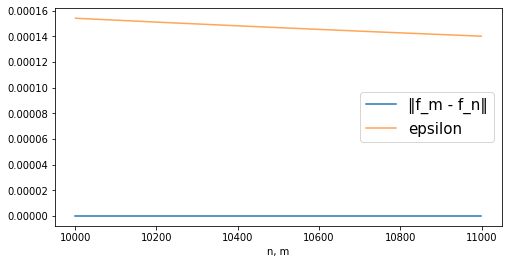

In [7]:
from matplotlib import pyplot as plt
import sympy as sym
from IPython.display import display, Math

x, n, m = sym.symbols('x, n, m') 
expn = sym.sin(x)**2

f = lambda n: sym.expand_trig(expn)/n
F = lambda f: sym.Integral(f, (x, 0, 2))

display(Math("f_n(x) = "+ sym.latex(f(n))))
display(Math("\|f_m - f_n\| = "+ sym.latex(F(f(n) - f(m)))))

epsilons = []
distances = []

n_range = np.arange(10001, 11001, 2)
m_range = np.arange(10002, 11001, 2)

for n, m in zip(n_range, m_range):
    epsilon = np.sqrt(1.189/n**2 + 1.189/m**2)
    d = F(f(n) - f(m)).evalf()
    
    epsilons.append(epsilon)
    distances.append(d)
    
plt.figure(figsize=(8, 4))
plt.plot(n_range, distances)
plt.plot(n_range, epsilons, alpha=0.7)
plt.xlabel('n, m')
# plt.ylabel('value')
plt.legend(['‖f_m - f_n‖', 'epsilon'], prop={'size': 15})
plt.show()

In [9]:
from npmath.space import CSpace
import sympy as sym

x, n = sym.symbols('x n')

# 有界閉区間[0, π]
I = sym.Interval(0, sym.pi).closure
# C[0, π]
C = CSpace(I, step=1e-2)

f_n = sym.sin(x)/n

# コーシー列が収束するか
C.check_pseudo_cauchy_sequence_convergence(
    f_n,
    x_symbol=x,
    n_symbol=n,
    interval=I,
    N=10001,
    epsilon=1e-7
)

In [10]:
try:
    C.check_pseudo_cauchy_sequence_convergence(
        n/(x+1e-10),
        x_symbol=x,
        n_symbol=n,
        interval=I,
        N=10001,
        epsilon=1e-7
    )
except Exception as e:
    print(f"{e.__class__.__name__}: {e}")

CauchySequenceNoConvergenceError: 10000000000.0000 > 1e-07, x=0.0, m=16424, n=16423


In [11]:
f, g = C.take(sym.sin(x), sym.cos(x), symbols=[x, x])

print("f(π/2): ", f({x: sym.pi/2}))
print("g(0): ", g({x: 0}))
print("(f + g)(π): ", (f + g)({x: sym.pi}))
print("2 * (f + g)(π): ", 2 * (f + g)({x: sym.pi}))
print("(f * g)(π/3): ", (f * g)({x: sym.pi/3}))
print("‖f‖: ", C.norm(f, x))
print("‖g‖: ", C.norm(g, x))

f(π/2):  1.00000000000000
g(0):  1.00000000000000
(f + g)(π):  -1.00000000000000
2 * (f + g)(π):  -2.00000000000000
(f * g)(π/3):  0.433012701892219
‖f‖:  0.999999682931835
‖g‖:  1.00000000000000


# 不連続性の確認

In [12]:
x = sym.symbols('x')
try:
    h = C.take(sym.Piecewise(
        (x, (x >= 0) & (x < 1)), 
        (10, sym.Eq(x, 1)),
        (x, (x > 1) & (x <= sym.pi))
    ), symbols=[x])
except Exception as e:
    print(f"{e.__class__.__name__}: {e}")

DiscontinuousFunctionError: f is discontinuas at x=1.0


# 定義域外の挙動

In [13]:
try:
    f({x: 100})
except Exception as e:
    print(f"{e.__class__.__name__}: {e}")

OutOfIntervalError: 100 not in Interval(0, pi)
